# install deepxde

In [1]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 14.8 MB/s eta 0:00:00


Compiling model...
Building feed-forward neural network...
'build' took 0.171837 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 4.241392 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [6.89e-19, 2.87e-15, 2.87e-15, 2.87e-15, 1.93e-01]    [6.80e-19, 2.87e-15, 2.87e-15, 2.87e-15, 1.93e-01]    []  
1000      [1.13e-21, 2.36e-19, 2.36e-19, 2.36e-19, 8.86e-16]    [1.12e-21, 2.36e-19, 2.36e-19, 2.36e-19, 8.86e-16]    []  
2000      [1.13e-21, 2.36e-19, 2.36e-19, 2.36e-19, 8.86e-16]    [1.12e-21, 2.36e-19, 2.36e-19, 2.36e-19, 8.86e-16]    []  
3000      [1.13e-21, 2.36e-19, 2.36e-19, 2.36e-19, 8.86e-16]    [1.12e-21, 2.36e-19, 2.36e-19, 2.36e-19, 8.86e-16]    []  
4000      [1.13e-21, 2.36e-19, 2.36e-19, 2.36e-19, 8.73e-16]    [1.12e-21, 2.36e-19, 2.36e-19, 2.36e-19, 8.73e-16]    []  
5000      [1.13e-21, 2.36e-19, 2.36e-19, 2.36e-19, 8.73e-16]    [1.12e-21, 2.36e-19, 2.36e-19, 2.36e-19, 8.73e-16]    []  
6000      [1.13e-21, 2.36e-19, 2.36e-19, 2.36e-19, 9.84e-16]    [1.12e-21, 2.36e-19, 2

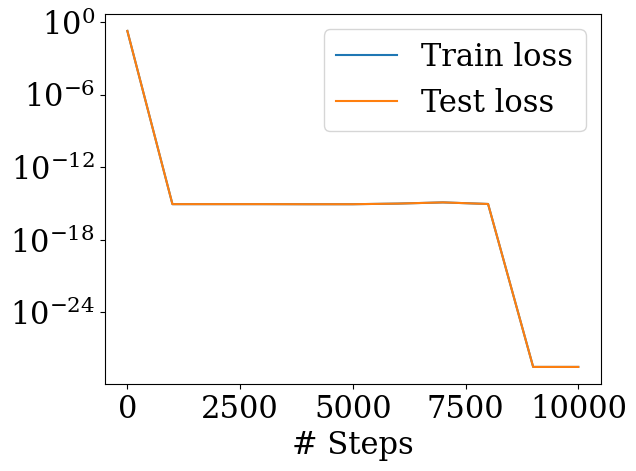

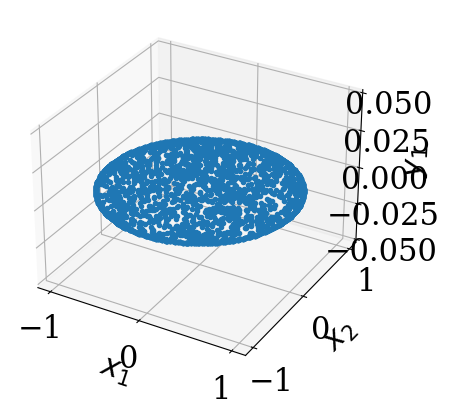

In [19]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

R = 1

num_dense_layers = 10
num_dense_nodes = 275
lr = 0.003

def pde(x, y):
  du_xx = dde.grad.hessian(y, x, i=0, j=0)
  du_yy = dde.grad.hessian(y, x, i=1, j=1)

  return du_xx + du_yy

def boundary(x, on_boundary):
  return on_boundary

def boundary_top(x, on_boundary):
  return on_boundary and np.allclose(x, [0, 1])

def boundary_bottom(x, on_boundary):
  return on_boundary and np.allclose(x, [0, -1])

def boundary_left_right(x, on_boundary):
  return on_boundary and not boundary_top(x, on_boundary) and not boundary_bottom(x, on_boundary)

def boundary_d(x, on_boundary):
  return on_boundary and np.allclose(x, [0, 0])

geom = dde.geometry.Disk([0,0], R)

bc_top = dde.icbc.NeumannBC(geom, lambda x : 1 if boundary_top(x, True) else 0, boundary)
bc_bottom = dde.icbc.NeumannBC(geom, lambda x : -1 if boundary_bottom(x,True) else 0, boundary)
bc_round = dde.icbc.NeumannBC(geom, lambda x : 0 if boundary_left_right(x, True) else 0, boundary)
bc_d = dde.icbc.DirichletBC(geom, lambda x : 0 if boundary_d(x, True) else 0, boundary)

data = dde.data.PDE(geom, pde, [bc_top, bc_bottom, bc_round, bc_d], num_domain=3000, num_boundary=300, num_test=1500)

layer_size = [2] + [num_dense_nodes] * num_dense_layers + [1]
activation = 'sigmoid'
net = dde.nn.FNN(layer_size, activation, "Glorot uniform")
model = dde.Model(data, net)

model.compile("adam", lr=lr)
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

<ipython-input-20-504da82e210f>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("seismic"),


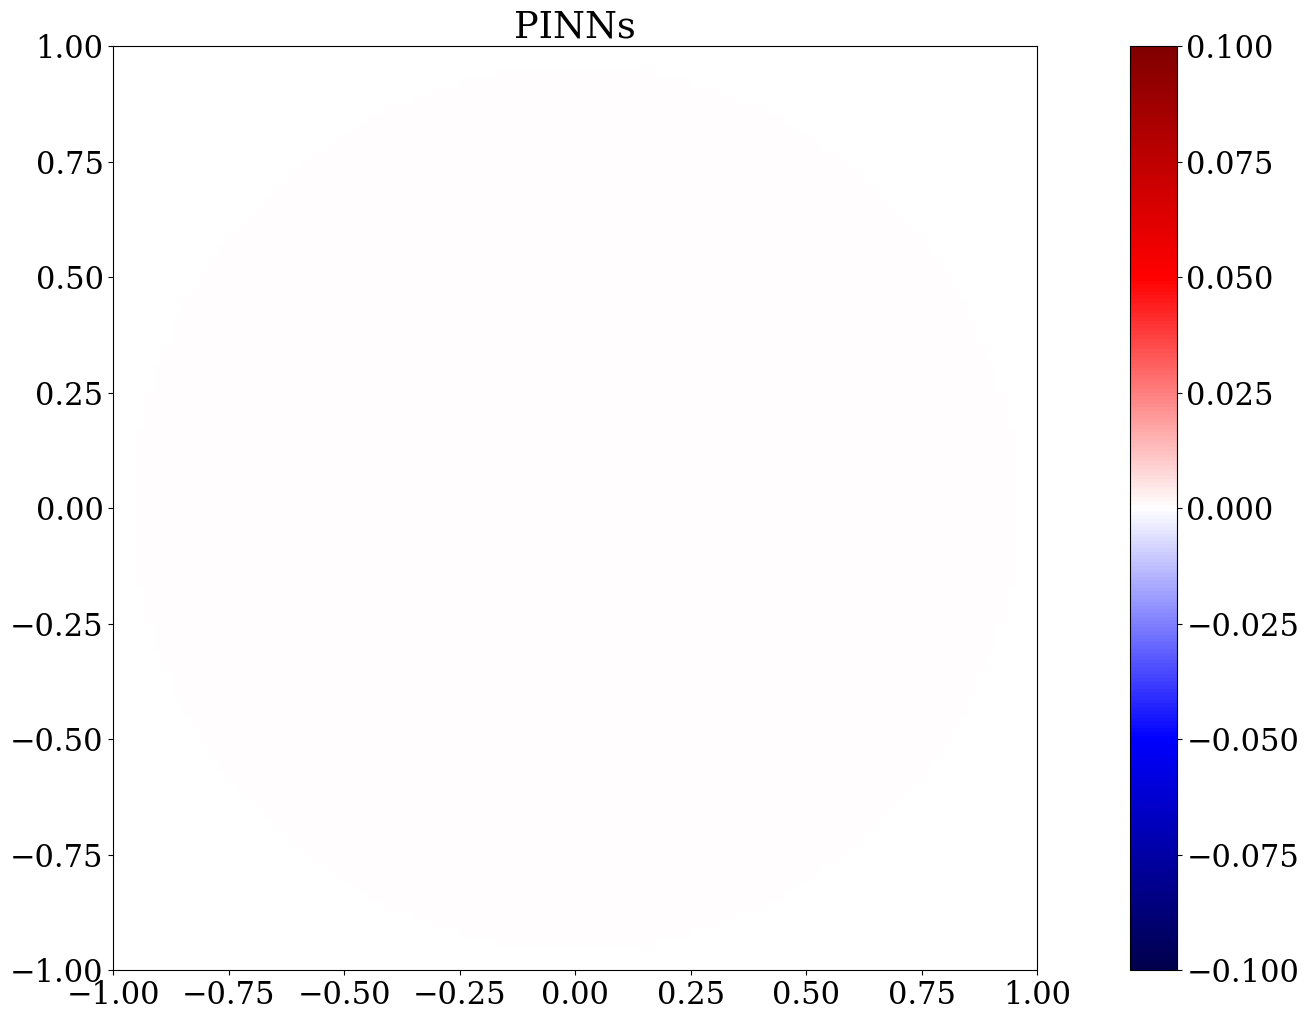

In [20]:
Nx = 100
Ny = 100

xmin, xmax, ymin, ymax = [-1, 1, -1, 1]
plot_gird = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]
points = np.vstack(
    (plot_gird[0].ravel(), plot_gird[1].ravel(), np.zeros(plot_gird[0].size))
)

points_2d = points[:2,:]
u = model.predict(points[:2,:].T)
u = u.reshape((Nx, Ny))

ide = np.sqrt(points_2d[0, :]**2 + points_2d[1,:]**2) > R
ide = ide.reshape((Nx, Nx))

plt.rc("font", family="serif", size=22)

fig, ax1 = plt.subplots(1, sharey=True, figsize=(24,12))

matrix = np.fliplr(u).T
matrix = np.ma.masked_where(ide, matrix)

pcm = ax1.imshow(
    matrix,
    extent=[-1,1,-1,1],
    cmap=plt.cm.get_cmap("seismic"),
    interpolation="spline16",
    label="PINN",
)

fig.colorbar(pcm, ax=ax1)

ax1.set_title("PINNs")

plt.savefig("plot_manufactured.pdf")

0 it number
learning rate : 1.0e-03
num_dense_layers: 4
num_dense_nodes: 50
activation: tanh

Compiling model...
Building feed-forward neural network...
'build' took 0.092479 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.791813 s

Training model...

0         [7.27e-03, 6.28e-03, 6.28e-03, 6.28e-03, 1.15e-02]    [7.19e-03, 6.28e-03, 6.28e-03, 6.28e-03, 1.15e-02]    []  
1000      [1.16e-07, 7.27e-09, 7.27e-09, 7.27e-09, 4.65e-09]    [1.05e-07, 7.27e-09, 7.27e-09, 7.27e-09, 4.65e-09]    []  
2000      [8.77e-09, 6.17e-10, 6.17e-10, 6.17e-10, 4.22e-11]    [7.90e-09, 6.17e-10, 6.17e-10, 6.17e-10, 4.22e-11]    []  
3000      [2.72e-06, 9.31e-06, 9.31e-06, 9.31e-06, 2.01e-05]    [2.63e-06, 9.31e-06, 9.31e-06, 9.31e-06, 2.01e-05]    []  
4000      [3.41e-09, 5.16e-10, 5.16e-10, 5.16e-10, 1.61e-10]    [3.02e-09, 5.16e-10, 5.16e-10, 5.16e-10, 1.61e-10]    []  
5000      [1.69e-09, 5.50e-10, 5.50e-10, 5.50e-10, 3.01e-11]    [1.43e-09, 5.50e-10, 5.50e-10, 5.50e-10, 3.01e-11]    []  
6000      [2.63e-09, 3.70e-09, 3.70e-09, 3.70e-09, 4.21e-09]    [1.99e-09, 3.70e-09, 3.70e-09, 3.70e-09, 4.21e-09]    []  
7000      [2.04e-09, 8.80e-10, 8.80e-10, 8.80e-10, 2.40e-10]    [1.56e-09, 8.80e-10, 8.80e-10

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.633471 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [5.15e-05, 1.08e-02, 1.08e-02, 1.08e-02, 1.14e-02]    [4.74e-05, 1.08e-02, 1.08e-02, 1.08e-02, 1.14e-02]    []  
1000      [7.81e-01, 1.52e-01, 1.52e-01, 1.52e-01, 2.88e-01]    [7.43e-01, 1.52e-01, 1.52e-01, 1.52e-01, 2.88e-01]    []  
2000      [2.19e-01, 1.34e-01, 1.34e-01, 1.34e-01, 2.29e-01]    [1.99e-01, 1.34e-01, 1.34e-01, 1.34e-01, 2.29e-01]    []  
3000      [1.16e-01, 1.04e-01, 1.04e-01, 1.04e-01, 1.70e-01]    [1.07e-01, 1.04e-01, 1.04e-01, 1.04e-01, 1.70e-01]    []  
4000      [5.98e-02, 5.70e-02, 5.70e-02, 5.70e-02, 8.31e-02]    [5.21e-02, 5.70e-02, 5.70e-02, 5.70e-02, 8.31e-02]    []  
5000      [2.12e-02, 1.06e-02, 1.06e-02, 1.06e-02, 1.89e-02]    [2.00e-02, 1.06e-02, 1.06e-02, 1.06e-02, 1.89e-02]    []  
6000      [7.05e-05, 1.65e-05, 1.65e-05, 1.65e-05, 1.58e-05]    [5.62e-05, 1.65e-05, 1

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.046324 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.19e-04, 2.79e-03, 2.79e-03, 2.79e-03, 3.19e-03]    [1.09e-04, 2.79e-03, 2.79e-03, 2.79e-03, 3.19e-03]    []  
1000      [2.75e-09, 9.73e-10, 9.73e-10, 9.73e-10, 4.04e-10]    [2.52e-09, 9.73e-10, 9.73e-10, 9.73e-10, 4.04e-10]    []  
2000      [4.05e-10, 1.39e-10, 1.39e-10, 1.39e-10, 5.42e-11]    [3.69e-10, 1.39e-10, 1.39e-10, 1.39e-10, 5.42e-11]    []  
3000      [1.17e-10, 9.98e-12, 9.98e-12, 9.98e-12, 3.92e-12]    [1.07e-10, 9.98e-12, 9.98e-12, 9.98e-12, 3.92e-12]    []  
4000      [4.19e-10, 6.76e-10, 6.76e-10, 6.76e-10, 1.67e-10]    [3.78e-10, 6.76e-10, 6.76e-10, 6.76e-10, 1.67e-10]    []  
5000      [2.85e-11, 1.14e-10, 1.14e-10, 1.14e-10, 2.73e-11]    [2.60e-11, 1.14e-10, 1.14e-10, 1.14e-10, 2.73e-11]    []  
6000      [9.68e-10, 3.50e-10, 3.50e-10, 3.50e-10, 3.49e-08]    [9.15e-10, 3.50e-10, 3

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.434742 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [7.68e-03, 2.31e-01, 2.31e-01, 2.31e-01, 2.60e-01]    [7.17e-03, 2.31e-01, 2.31e-01, 2.31e-01, 2.60e-01]    []  
1000      [7.35e-06, 1.28e-05, 1.28e-05, 1.28e-05, 1.81e-06]    [6.74e-06, 1.28e-05, 1.28e-05, 1.28e-05, 1.81e-06]    []  
2000      [1.24e-06, 6.86e-07, 6.86e-07, 6.86e-07, 1.25e-07]    [1.13e-06, 6.86e-07, 6.86e-07, 6.86e-07, 1.25e-07]    []  
3000      [2.60e-07, 3.49e-08, 3.49e-08, 3.49e-08, 5.11e-09]    [2.32e-07, 3.49e-08, 3.49e-08, 3.49e-08, 5.11e-09]    []  
4000      [1.58e-07, 2.10e-08, 2.10e-08, 2.10e-08, 2.01e-09]    [1.40e-07, 2.10e-08, 2.10e-08, 2.10e-08, 2.01e-09]    []  
5000      [1.24e-07, 1.80e-08, 1.80e-08, 1.80e-08, 1.63e-09]    [1.09e-07, 1.80e-08, 1.80e-08, 1.80e-08, 1.63e-09]    []  
6000      [1.05e-07, 1.61e-08, 1.61e-08, 1.61e-08, 4.17e-09]    [9.10e-08, 1.61e-08, 1

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.638698 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.88e-04, 5.41e-02, 5.41e-02, 5.41e-02, 5.68e-02]    [2.58e-04, 5.41e-02, 5.41e-02, 5.41e-02, 5.68e-02]    []  
1000      [1.36e-07, 2.43e-07, 2.43e-07, 2.43e-07, 3.42e-08]    [1.16e-07, 2.43e-07, 2.43e-07, 2.43e-07, 3.42e-08]    []  
2000      [2.06e-08, 4.02e-08, 4.02e-08, 4.02e-08, 2.07e-07]    [1.65e-08, 4.02e-08, 4.02e-08, 4.02e-08, 2.07e-07]    []  
3000      [3.43e-09, 2.15e-09, 2.15e-09, 2.15e-09, 2.33e-10]    [2.38e-09, 2.15e-09, 2.15e-09, 2.15e-09, 2.33e-10]    []  
4000      [2.32e-09, 4.34e-10, 4.34e-10, 4.34e-10, 1.08e-07]    [1.81e-09, 4.34e-10, 4.34e-10, 4.34e-10, 1.08e-07]    []  
5000      [2.13e-09, 1.20e-09, 1.20e-09, 1.20e-09, 1.30e-09]    [1.71e-09, 1.20e-09, 1.20e-09, 1.20e-09, 1.30e-09]    []  
6000      [2.13e-09, 3.75e-12, 3.75e-12, 3.75e-12, 7.57e-12]    [1.70e-09, 3.74e-12, 3

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.057339 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [9.77e-05, 8.14e-03, 8.14e-03, 8.14e-03, 8.64e-03]    [9.19e-05, 8.14e-03, 8.14e-03, 8.14e-03, 8.64e-03]    []  
1000      [9.95e-09, 4.64e-10, 4.64e-10, 4.64e-10, 3.80e-11]    [8.37e-09, 4.64e-10, 4.64e-10, 4.64e-10, 3.80e-11]    []  
2000      [7.91e-10, 1.59e-10, 1.59e-10, 1.59e-10, 9.13e-12]    [6.67e-10, 1.59e-10, 1.59e-10, 1.59e-10, 9.13e-12]    []  
3000      [2.96e-09, 7.12e-08, 7.12e-08, 7.12e-08, 8.06e-08]    [2.96e-09, 7.12e-08, 7.12e-08, 7.12e-08, 8.06e-08]    []  
4000      [3.01e-10, 2.00e-11, 2.00e-11, 2.00e-11, 3.20e-12]    [2.49e-10, 2.00e-11, 2.00e-11, 2.00e-11, 3.20e-12]    []  
5000      [2.92e-10, 1.41e-10, 1.41e-10, 1.41e-10, 1.32e-10]    [2.41e-10, 1.41e-10, 1.41e-10, 1.41e-10, 1.32e-10]    []  
6000      [2.39e-10, 7.93e-12, 7.93e-12, 7.93e-12, 8.94e-10]    [1.93e-10, 7.93e-12, 7

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.750043 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.01e-03, 4.38e-02, 4.38e-02, 4.38e-02, 4.98e-02]    [1.88e-03, 4.38e-02, 4.38e-02, 4.38e-02, 4.98e-02]    []  
1000      [3.65e-07, 1.87e-08, 1.87e-08, 1.87e-08, 4.13e-09]    [3.03e-07, 1.87e-08, 1.87e-08, 1.87e-08, 4.13e-09]    []  
2000      [8.05e-08, 3.39e-09, 3.39e-09, 3.39e-09, 5.12e-10]    [6.56e-08, 3.39e-09, 3.39e-09, 3.39e-09, 5.12e-10]    []  
3000      [6.87e-08, 2.35e-09, 2.35e-09, 2.35e-09, 2.04e-10]    [5.72e-08, 2.35e-09, 2.35e-09, 2.35e-09, 2.04e-10]    []  
4000      [1.41e-08, 3.76e-10, 3.76e-10, 3.76e-10, 1.17e-10]    [1.13e-08, 3.76e-10, 3.76e-10, 3.76e-10, 1.17e-10]    []  
5000      [1.18e-08, 1.64e-09, 1.64e-09, 1.64e-09, 2.37e-10]    [1.01e-08, 1.64e-09, 1.64e-09, 1.64e-09, 2.37e-10]    []  
6000      [7.78e-09, 2.51e-09, 2.51e-09, 2.51e-09, 2.73e-08]    [6.55e-09, 2.51e-09, 2

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.980997 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [9.55e-05, 7.56e-03, 7.56e-03, 7.56e-03, 8.14e-03]    [9.07e-05, 7.56e-03, 7.56e-03, 7.56e-03, 8.14e-03]    []  
1000      [7.50e-01, 3.48e-02, 3.48e-02, 3.48e-02, 6.75e-03]    [8.13e-01, 3.48e-02, 3.48e-02, 3.48e-02, 6.75e-03]    []  
2000      [2.21e-01, 7.10e-03, 7.10e-03, 7.10e-03, 2.68e-03]    [2.49e-01, 7.10e-03, 7.10e-03, 7.10e-03, 2.68e-03]    []  
3000      [9.71e-02, 2.30e-03, 2.30e-03, 2.30e-03, 7.73e-04]    [1.15e-01, 2.30e-03, 2.30e-03, 2.30e-03, 7.73e-04]    []  
4000      [8.38e-02, 1.33e-03, 1.33e-03, 1.33e-03, 1.80e-04]    [9.20e-02, 1.33e-03, 1.33e-03, 1.33e-03, 1.80e-04]    []  
5000      [2.18e-02, 4.99e-04, 4.99e-04, 4.99e-04, 4.32e-05]    [2.70e-02, 4.99e-04, 4.99e-04, 4.99e-04, 4.32e-05]    []  
6000      [1.21e-02, 2.93e-04, 2.93e-04, 2.93e-04, 2.15e-05]    [1.45e-02, 2.93e-04, 2

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.554371 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [5.85e-07, 8.36e-03, 8.36e-03, 8.36e-03, 8.40e-03]    [5.44e-07, 8.36e-03, 8.36e-03, 8.36e-03, 8.40e-03]    []  
1000      [2.57e-07, 5.64e-09, 5.64e-09, 5.64e-09, 1.64e-08]    [2.33e-07, 5.64e-09, 5.64e-09, 5.64e-09, 1.64e-08]    []  
2000      [2.06e-07, 5.40e-09, 5.40e-09, 5.40e-09, 3.37e-08]    [1.87e-07, 5.40e-09, 5.40e-09, 5.40e-09, 3.37e-08]    []  
3000      [1.40e-07, 5.08e-09, 5.08e-09, 5.08e-09, 9.12e-09]    [1.27e-07, 5.08e-09, 5.08e-09, 5.08e-09, 9.12e-09]    []  
4000      [7.32e-08, 4.70e-09, 4.70e-09, 4.70e-09, 4.98e-09]    [6.64e-08, 4.70e-09, 4.70e-09, 4.70e-09, 4.98e-09]    []  
5000      [2.69e-08, 4.19e-09, 4.19e-09, 4.19e-09, 3.21e-09]    [2.44e-08, 4.19e-09, 4.19e-09, 4.19e-09, 3.21e-09]    []  
6000      [7.31e-09, 3.33e-09, 3.33e-09, 3.33e-09, 4.21e-09]    [6.64e-09, 3.33e-09, 3

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.207321 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [6.70e-04, 1.03e-02, 1.03e-02, 1.03e-02, 1.22e-02]    [6.31e-04, 1.03e-02, 1.03e-02, 1.03e-02, 1.22e-02]    []  
1000      [4.72e-08, 1.09e-08, 1.09e-08, 1.09e-08, 5.49e-10]    [4.17e-08, 1.09e-08, 1.09e-08, 1.09e-08, 5.49e-10]    []  
2000      [2.11e-08, 6.24e-09, 6.24e-09, 6.24e-09, 3.13e-10]    [1.88e-08, 6.24e-09, 6.24e-09, 6.24e-09, 3.13e-10]    []  
3000      [1.16e-08, 4.25e-09, 4.25e-09, 4.25e-09, 2.05e-10]    [1.03e-08, 4.25e-09, 4.25e-09, 4.25e-09, 2.05e-10]    []  
4000      [4.38e-09, 2.12e-09, 2.12e-09, 2.12e-09, 9.93e-11]    [3.87e-09, 2.12e-09, 2.12e-09, 2.12e-09, 9.93e-11]    []  
5000      [3.42e-09, 8.04e-10, 8.04e-10, 8.04e-10, 4.05e-11]    [2.82e-09, 8.04e-10, 8.04e-10, 8.04e-10, 4.05e-11]    []  
6000      [2.98e-09, 7.80e-10, 7.80e-10, 7.80e-10, 4.08e-11]    [2.47e-09, 7.80e-10, 7

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.227413 s

'compile' took 2.990980 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.64e-04, 1.61e-02, 1.61e-02, 1.61e-02, 1.75e-02]    [2.45e-04, 1.61e-02, 1.61e-02, 1.61e-02, 1.75e-02]    []  
1000      [4.53e-09, 8.29e-09, 8.29e-09, 8.29e-09, 1.26e-09]    [4.15e-09, 8.29e-09, 8.29e-09, 8.29e-09, 1.26e-09]    []  
2000      [5.89e-09, 2.96e-09, 2.96e-09, 2.96e-09, 5.32e-10]    [5.66e-09, 2.96e-09, 2.96e-09, 2.96e-09, 5.32e-10]    []  
3000      [3.70e-10, 7.94e-10, 7.94e-10, 7.94e-10, 1.73e-07]    [3.60e-10, 7.94e-10, 7.94e-10, 7.94e-10, 1.73e-07]    []  
4000      [1.81e-10, 2.39e-10, 2.39e-10, 2.39e-10, 1.73e-08]    [1.76e-10, 2.39e-10, 2.39e-10, 2.39e-10, 1.73e-08]    []  
5000      [4.39e-11, 7.93e-11, 7.93e-11, 7.93e-11, 1.30e-11]    [4.37e-11, 7.93e-11, 7.93e-11, 7.93e-11, 1.30e-11]    []  
6000      [2.11e-10, 1.11e-10, 1.11e-10, 1.11e-10, 2.74e-10] 

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.016270 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [9.94e-07, 1.97e-03, 1.97e-03, 1.97e-03, 2.00e-03]    [9.33e-07, 1.97e-03, 1.97e-03, 1.97e-03, 2.00e-03]    []  
1000      [nan, nan, nan, nan, nan]                             [nan, nan, nan, nan, nan]                             []  

Best model at step 0:
  train loss: 7.92e-03
  test loss: 7.92e-03
  test metric: []

'train' took 101.128113 s

22 it number
learning rate : 1.2e-03
num_dense_layers: 7
num_dense_nodes: 262
activation: tanh

Compiling model...
Building feed-forward neural network...
'build' took 0.127883 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.534726 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [5.74e-04, 8.49e-03, 8.49e-03, 8.49e-03, 1.00e-02]    [5.46e-04, 8.49e-03, 8.49e-03, 8.49e-03, 1.00e-02]    []  
1000      [1.22e-09, 1.80e-09, 1.80e-09, 1.80e-09, 4.05e-10]    [1.23e-09, 1.80e-09, 1.80e-09, 1.80e-09, 4.05e-10]    []  
2000      [8.60e-11, 2.27e-10, 2.27e-10, 2.27e-10, 6.57e-11]    [8.14e-11, 2.27e-10, 2.27e-10, 2.27e-10, 6.57e-11]    []  
3000      [6.25e-11, 9.62e-12, 9.62e-12, 9.62e-12, 2.77e-12]    [5.63e-11, 9.62e-12, 9.62e-12, 9.62e-12, 2.77e-12]    []  
4000      [4.33e-11, 2.85e-11, 2.85e-11, 2.85e-11, 5.22e-12]    [3.84e-11, 2.85e-11, 2.85e-11, 2.85e-11, 5.22e-12]    []  
5000      [5.53e-11, 7.51e-10, 7.51e-10, 7.51e-10, 1.08e-10]    [5.48e-11, 7.51e-10, 7.51e-10, 7.51e-10, 1.08e-10]    []  
6000      [4.39e-12, 1.82e-11, 1.82e-11, 1.82e-11, 4.87e-12]    [3.83e-12, 1.82e-11, 1

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 4.284736 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.40e-04, 1.37e-02, 1.37e-02, 1.37e-02, 1.49e-02]    [2.17e-04, 1.37e-02, 1.37e-02, 1.37e-02, 1.49e-02]    []  
1000      [6.91e-08, 5.23e-08, 5.23e-08, 5.23e-08, 1.20e-08]    [6.20e-08, 5.23e-08, 5.23e-08, 5.23e-08, 1.20e-08]    []  
2000      [2.89e-08, 1.16e-08, 1.16e-08, 1.16e-08, 3.06e-09]    [2.60e-08, 1.16e-08, 1.16e-08, 1.16e-08, 3.06e-09]    []  
3000      [5.29e-09, 4.25e-09, 4.25e-09, 4.25e-09, 7.84e-10]    [4.81e-09, 4.25e-09, 4.25e-09, 4.25e-09, 7.84e-10]    []  
4000      [7.89e-10, 1.15e-09, 1.15e-09, 1.15e-09, 1.78e-10]    [7.34e-10, 1.15e-09, 1.15e-09, 1.15e-09, 1.78e-10]    []  
5000      [1.25e-10, 1.15e-09, 1.15e-09, 1.15e-09, 2.57e-10]    [1.10e-10, 1.15e-09, 1.15e-09, 1.15e-09, 2.57e-10]    []  
6000      [1.15e-10, 4.15e-10, 4.15e-10, 4.15e-10, 7.26e-11]    [1.00e-10, 4.15e-10, 4

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.435548 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.72e-04, 6.17e-03, 6.17e-03, 6.17e-03, 7.07e-03]    [2.63e-04, 6.17e-03, 6.17e-03, 6.17e-03, 7.07e-03]    []  
1000      [1.39e-08, 4.33e-05, 4.33e-05, 4.33e-05, 4.37e-05]    [1.35e-08, 4.33e-05, 4.33e-05, 4.33e-05, 4.37e-05]    []  
2000      [2.30e-10, 6.92e-10, 6.92e-10, 6.92e-10, 9.75e-11]    [2.07e-10, 6.92e-10, 6.92e-10, 6.92e-10, 9.75e-11]    []  
3000      [3.42e-11, 4.03e-11, 4.03e-11, 4.03e-11, 6.50e-12]    [2.82e-11, 4.03e-11, 4.03e-11, 4.03e-11, 6.50e-12]    []  
4000      [3.06e-08, 2.43e-07, 2.43e-07, 2.43e-07, 1.97e-07]    [2.88e-08, 2.43e-07, 2.43e-07, 2.43e-07, 1.97e-07]    []  
5000      [1.28e-11, 1.83e-10, 1.83e-10, 1.83e-10, 2.38e-07]    [1.18e-11, 1.83e-10, 1.83e-10, 1.83e-10, 2.38e-07]    []  
6000      [5.35e-12, 6.84e-13, 6.84e-13, 6.84e-13, 1.23e-13]    [4.03e-12, 6.84e-13, 6

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.017391 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.11e-16, 1.41e-12, 1.41e-12, 1.41e-12, 1.73e+00]    [1.96e-16, 1.41e-12, 1.41e-12, 1.41e-12, 1.73e+00]    []  
1000      [1.92e-16, 2.90e-14, 2.90e-14, 2.90e-14, 3.64e-14]    [1.92e-16, 2.90e-14, 2.90e-14, 2.90e-14, 3.64e-14]    []  
2000      [1.91e-16, 2.84e-14, 2.84e-14, 2.84e-14, 3.63e-14]    [1.92e-16, 2.84e-14, 2.84e-14, 2.84e-14, 3.63e-14]    []  
3000      [1.91e-16, 2.77e-14, 2.77e-14, 2.77e-14, 3.28e-14]    [1.91e-16, 2.77e-14, 2.77e-14, 2.77e-14, 3.28e-14]    []  
4000      [1.90e-16, 2.70e-14, 2.70e-14, 2.70e-14, 3.25e-14]    [1.91e-16, 2.70e-14, 2.70e-14, 2.70e-14, 3.25e-14]    []  
5000      [1.90e-16, 2.62e-14, 2.62e-14, 2.62e-14, 3.28e-14]    [1.90e-16, 2.62e-14, 2.62e-14, 2.62e-14, 3.28e-14]    []  
6000      [1.33e-20, 2.45e-18, 2.45e-18, 2.45e-18, 2.45e-12]    [1.33e-20, 2.45e-18, 2

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.091618 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.06e-17, 4.51e-14, 4.51e-14, 4.51e-14, 2.17e-01]    [1.79e-17, 4.51e-14, 4.51e-14, 4.51e-14, 2.17e-01]    []  
1000      [6.85e-18, 7.25e-15, 7.25e-15, 7.25e-15, 1.37e-14]    [5.94e-18, 7.25e-15, 7.25e-15, 7.25e-15, 1.37e-14]    []  
2000      [6.84e-18, 7.23e-15, 7.23e-15, 7.23e-15, 1.32e-14]    [5.93e-18, 7.23e-15, 7.23e-15, 7.23e-15, 1.32e-14]    []  
3000      [6.82e-18, 7.20e-15, 7.20e-15, 7.20e-15, 1.26e-14]    [5.92e-18, 7.20e-15, 7.20e-15, 7.20e-15, 1.26e-14]    []  
4000      [6.81e-18, 7.18e-15, 7.18e-15, 7.18e-15, 1.36e-14]    [5.91e-18, 7.18e-15, 7.18e-15, 7.18e-15, 1.36e-14]    []  
5000      [6.79e-18, 7.15e-15, 7.15e-15, 7.15e-15, 1.39e-14]    [5.89e-18, 7.15e-15, 7.15e-15, 7.15e-15, 1.39e-14]    []  
6000      [6.64e-19, 2.82e-15, 2.82e-15, 2.82e-15, 7.37e-15]    [6.04e-19, 2.82e-15, 2

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.383577 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.24e-16, 1.48e-12, 1.48e-12, 1.48e-12, 8.52e-01]    [1.14e-16, 1.48e-12, 1.48e-12, 1.48e-12, 8.52e-01]    []  
1000      [1.07e-21, 1.99e-17, 1.99e-17, 1.99e-17, 1.31e-15]    [9.65e-22, 1.99e-17, 1.99e-17, 1.99e-17, 1.31e-15]    []  
2000      [1.07e-21, 1.99e-17, 1.99e-17, 1.99e-17, 1.31e-15]    [9.65e-22, 1.99e-17, 1.99e-17, 1.99e-17, 1.31e-15]    []  
3000      [1.07e-21, 1.99e-17, 1.99e-17, 1.99e-17, 1.30e-15]    [9.65e-22, 1.99e-17, 1.99e-17, 1.99e-17, 1.30e-15]    []  
4000      [1.07e-21, 1.99e-17, 1.99e-17, 1.99e-17, 1.30e-15]    [9.65e-22, 1.99e-17, 1.99e-17, 1.99e-17, 1.30e-15]    []  
5000      [1.07e-21, 1.99e-17, 1.99e-17, 1.99e-17, 1.30e-15]    [9.65e-22, 1.99e-17, 1.99e-17, 1.99e-17, 1.30e-15]    []  
6000      [1.07e-21, 1.99e-17, 1.99e-17, 1.99e-17, 1.30e-15]    [9.65e-22, 1.99e-17, 1

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.100424 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.14e-15, 1.45e-13, 1.45e-13, 1.45e-13, 1.01e+00]    [1.15e-15, 1.45e-13, 1.45e-13, 1.45e-13, 1.01e+00]    []  
1000      [2.47e-19, 3.04e-15, 3.04e-15, 3.04e-15, 3.03e-15]    [2.32e-19, 3.04e-15, 3.04e-15, 3.04e-15, 3.03e-15]    []  
2000      [2.47e-19, 3.04e-15, 3.04e-15, 3.04e-15, 3.01e-15]    [2.32e-19, 3.04e-15, 3.04e-15, 3.04e-15, 3.01e-15]    []  
3000      [2.47e-19, 3.04e-15, 3.04e-15, 3.04e-15, 2.93e-15]    [2.32e-19, 3.04e-15, 3.04e-15, 3.04e-15, 2.93e-15]    []  
4000      [2.47e-19, 3.04e-15, 3.04e-15, 3.04e-15, 2.38e-15]    [2.32e-19, 3.04e-15, 3.04e-15, 3.04e-15, 2.38e-15]    []  
5000      [2.47e-19, 3.04e-15, 3.04e-15, 3.04e-15, 3.24e-15]    [2.32e-19, 3.04e-15, 3.04e-15, 3.04e-15, 3.24e-15]    []  
6000      [9.84e-30, 3.67e-26, 3.67e-26, 3.67e-26, 1.36e-16]    [9.74e-30, 3.67e-26, 3

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 5.560140 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.15e-17, 1.73e-14, 1.73e-14, 1.73e-14, 1.78e-01]    [2.13e-17, 1.73e-14, 1.73e-14, 1.73e-14, 1.78e-01]    []  
1000      [3.44e-19, 3.66e-15, 3.66e-15, 3.66e-15, 5.97e-15]    [3.15e-19, 3.66e-15, 3.66e-15, 3.66e-15, 5.97e-15]    []  
2000      [3.44e-19, 3.66e-15, 3.66e-15, 3.66e-15, 6.79e-15]    [3.15e-19, 3.66e-15, 3.66e-15, 3.66e-15, 6.79e-15]    []  
3000      [3.43e-19, 3.65e-15, 3.65e-15, 3.65e-15, 6.36e-15]    [3.14e-19, 3.65e-15, 3.65e-15, 3.65e-15, 6.36e-15]    []  
4000      [3.43e-19, 3.65e-15, 3.65e-15, 3.65e-15, 5.87e-15]    [3.14e-19, 3.65e-15, 3.65e-15, 3.65e-15, 5.87e-15]    []  
5000      [3.43e-19, 3.65e-15, 3.65e-15, 3.65e-15, 6.25e-15]    [3.14e-19, 3.65e-15, 3.65e-15, 3.65e-15, 6.25e-15]    []  
6000      [3.04e-30, 2.02e-26, 2.02e-26, 2.02e-26, 1.95e-18]    [2.89e-30, 2.02e-26, 2

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.630056 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [5.14e-04, 2.09e-02, 2.09e-02, 2.09e-02, 2.27e-02]    [4.71e-04, 2.09e-02, 2.09e-02, 2.09e-02, 2.27e-02]    []  
1000      [9.26e-07, 2.55e-06, 2.55e-06, 2.55e-06, 3.37e-07]    [8.64e-07, 2.55e-06, 2.55e-06, 2.55e-06, 3.37e-07]    []  
2000      [2.30e-08, 6.35e-09, 6.35e-09, 6.35e-09, 5.97e-10]    [1.91e-08, 6.35e-09, 6.35e-09, 6.35e-09, 5.97e-10]    []  
3000      [2.24e-08, 8.36e-10, 8.36e-10, 8.36e-10, 1.01e-10]    [1.72e-08, 8.36e-10, 8.36e-10, 8.36e-10, 1.01e-10]    []  
4000      [2.21e-08, 8.31e-10, 8.31e-10, 8.31e-10, 1.00e-10]    [1.69e-08, 8.31e-10, 8.31e-10, 8.31e-10, 1.00e-10]    []  
5000      [4.61e-08, 1.21e-06, 1.21e-06, 1.21e-06, 1.47e-06]    [3.65e-08, 1.21e-06, 1.21e-06, 1.21e-06, 1.47e-06]    []  
6000      [2.10e-08, 8.22e-10, 8.22e-10, 8.22e-10, 9.51e-11]    [1.61e-08, 8.22e-10, 8

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.381130 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [4.82e-09, 3.23e-04, 3.23e-04, 3.23e-04, 4.16e-01]    [4.48e-09, 3.23e-04, 3.23e-04, 3.23e-04, 4.16e-01]    []  
1000      [7.11e-07, 1.18e-07, 1.18e-07, 1.18e-07, 1.81e-08]    [6.90e-07, 1.18e-07, 1.18e-07, 1.18e-07, 1.81e-08]    []  
2000      [6.37e-07, 1.14e-07, 1.14e-07, 1.14e-07, 1.44e-08]    [6.20e-07, 1.14e-07, 1.14e-07, 1.14e-07, 1.44e-08]    []  
3000      [5.39e-07, 1.07e-07, 1.07e-07, 1.07e-07, 9.82e-09]    [5.28e-07, 1.07e-07, 1.07e-07, 1.07e-07, 9.82e-09]    []  
4000      [4.34e-07, 9.77e-08, 9.77e-08, 9.77e-08, 5.48e-09]    [4.29e-07, 9.77e-08, 9.77e-08, 9.77e-08, 5.48e-09]    []  
5000      [3.40e-07, 8.47e-08, 8.47e-08, 8.47e-08, 2.48e-09]    [3.39e-07, 8.47e-08, 8.47e-08, 8.47e-08, 2.48e-09]    []  
6000      [2.59e-07, 6.77e-08, 6.77e-08, 6.77e-08, 1.00e-09]    [2.59e-07, 6.77e-08, 6

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.814757 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [8.59e-03, 1.71e-02, 1.71e-02, 1.71e-02, 2.61e-02]    [8.33e-03, 1.71e-02, 1.71e-02, 1.71e-02, 2.61e-02]    []  
1000      [1.50e-06, 1.30e-07, 1.30e-07, 1.30e-07, 6.18e-09]    [1.26e-06, 1.30e-07, 1.30e-07, 1.30e-07, 6.18e-09]    []  
2000      [2.00e-07, 5.45e-08, 5.45e-08, 5.45e-08, 2.83e-09]    [1.68e-07, 5.45e-08, 5.45e-08, 5.45e-08, 2.83e-09]    []  
3000      [2.85e-08, 2.24e-08, 2.24e-08, 2.24e-08, 1.14e-09]    [2.29e-08, 2.24e-08, 2.24e-08, 2.24e-08, 1.14e-09]    []  
4000      [1.08e-08, 9.16e-09, 9.16e-09, 9.16e-09, 6.18e-10]    [8.90e-09, 9.16e-09, 9.16e-09, 9.16e-09, 6.18e-10]    []  
5000      [1.97e-07, 5.09e-07, 5.09e-07, 5.09e-07, 7.40e-07]    [1.92e-07, 5.09e-07, 5.09e-07, 5.09e-07, 7.40e-07]    []  
6000      [7.53e-09, 3.35e-09, 3.35e-09, 3.35e-09, 3.41e-09]    [7.48e-09, 3.35e-09, 3

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.221987 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.34e-06, 6.90e-04, 6.90e-04, 6.90e-04, 2.25e-03]    [1.25e-06, 6.90e-04, 6.90e-04, 6.90e-04, 2.25e-03]    []  
1000      [6.71e-07, 1.31e-07, 1.31e-07, 1.31e-07, 5.42e-08]    [6.17e-07, 1.31e-07, 1.31e-07, 1.31e-07, 5.42e-08]    []  
2000      [3.14e-07, 1.02e-07, 1.02e-07, 1.02e-07, 3.02e-08]    [2.91e-07, 1.02e-07, 1.02e-07, 1.02e-07, 3.02e-08]    []  
3000      [8.96e-08, 6.91e-08, 6.91e-08, 6.91e-08, 1.33e-08]    [8.39e-08, 6.91e-08, 6.91e-08, 6.91e-08, 1.33e-08]    []  
4000      [1.85e-08, 3.85e-08, 3.85e-08, 3.85e-08, 5.49e-09]    [1.74e-08, 3.85e-08, 3.85e-08, 3.85e-08, 5.49e-09]    []  
5000      [5.79e-09, 1.54e-08, 1.54e-08, 1.54e-08, 1.69e-07]    [5.33e-09, 1.54e-08, 1.54e-08, 1.54e-08, 1.69e-07]    []  
6000      [1.55e-09, 3.51e-09, 3.51e-09, 3.51e-09, 8.75e-10]    [1.42e-09, 3.51e-09, 3

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.507299 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.92e-03, 3.33e-02, 3.33e-02, 3.33e-02, 3.89e-02]    [1.83e-03, 3.33e-02, 3.33e-02, 3.33e-02, 3.89e-02]    []  
1000      [2.93e-07, 2.81e-08, 2.81e-08, 2.81e-08, 1.47e-09]    [2.46e-07, 2.81e-08, 2.81e-08, 2.81e-08, 1.47e-09]    []  
2000      [2.01e-07, 2.37e-08, 2.37e-08, 2.37e-08, 5.41e-08]    [1.67e-07, 2.37e-08, 2.37e-08, 2.37e-08, 5.41e-08]    []  
3000      [1.22e-07, 1.87e-08, 1.87e-08, 1.87e-08, 2.87e-09]    [1.01e-07, 1.87e-08, 1.87e-08, 1.87e-08, 2.87e-09]    []  
4000      [7.21e-08, 2.82e-08, 2.82e-08, 2.82e-08, 1.63e-08]    [5.93e-08, 2.82e-08, 2.82e-08, 2.82e-08, 1.63e-08]    []  
5000      [4.07e-08, 1.37e-08, 1.37e-08, 1.37e-08, 1.62e-09]    [3.33e-08, 1.37e-08, 1.37e-08, 1.37e-08, 1.62e-09]    []  
6000      [6.78e-08, 7.56e-07, 7.56e-07, 7.56e-07, 9.82e-07]    [6.31e-08, 7.56e-07, 7

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.321211 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.24e-07, 1.98e-03, 1.98e-03, 1.98e-03, 4.76e-01]    [1.16e-07, 1.98e-03, 1.98e-03, 1.98e-03, 4.76e-01]    []  
1000      [3.56e-06, 3.55e-07, 3.55e-07, 3.55e-07, 1.34e-07]    [3.62e-06, 3.55e-07, 3.55e-07, 3.55e-07, 1.34e-07]    []  
2000      [3.00e-06, 3.35e-07, 3.35e-07, 3.35e-07, 1.06e-07]    [3.07e-06, 3.35e-07, 3.35e-07, 3.35e-07, 1.06e-07]    []  
3000      [2.31e-06, 3.09e-07, 3.09e-07, 3.09e-07, 7.43e-08]    [2.39e-06, 3.09e-07, 3.09e-07, 3.09e-07, 7.43e-08]    []  
4000      [1.63e-06, 2.79e-07, 2.79e-07, 2.79e-07, 4.54e-08]    [1.69e-06, 2.79e-07, 2.79e-07, 2.79e-07, 4.54e-08]    []  
5000      [1.05e-06, 2.38e-07, 2.38e-07, 2.38e-07, 2.54e-08]    [1.10e-06, 2.38e-07, 2.38e-07, 2.38e-07, 2.54e-08]    []  
6000      [6.31e-07, 1.79e-07, 1.79e-07, 1.79e-07, 1.42e-08]    [6.61e-07, 1.79e-07, 1

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.998943 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [3.33e-06, 8.94e-03, 8.94e-03, 8.94e-03, 1.17e-02]    [2.88e-06, 8.94e-03, 8.94e-03, 8.94e-03, 1.17e-02]    []  
1000      [8.71e-07, 8.61e-09, 8.61e-09, 8.61e-09, 5.32e-08]    [7.55e-07, 8.61e-09, 8.61e-09, 8.61e-09, 5.32e-08]    []  
2000      [7.92e-07, 8.77e-09, 8.77e-09, 8.77e-09, 4.85e-08]    [6.87e-07, 8.77e-09, 8.77e-09, 8.77e-09, 4.85e-08]    []  
3000      [6.74e-07, 9.83e-09, 9.83e-09, 9.83e-09, 4.15e-08]    [5.85e-07, 9.83e-09, 9.83e-09, 9.83e-09, 4.15e-08]    []  
4000      [5.23e-07, 1.27e-08, 1.27e-08, 1.27e-08, 3.28e-08]    [4.54e-07, 1.27e-08, 1.27e-08, 1.27e-08, 3.28e-08]    []  
5000      [3.59e-07, 1.83e-08, 1.83e-08, 1.83e-08, 2.35e-08]    [3.11e-07, 1.83e-08, 1.83e-08, 1.83e-08, 2.35e-08]    []  
6000      [2.12e-07, 2.53e-08, 2.53e-08, 2.53e-08, 1.55e-08]    [1.84e-07, 2.53e-08, 2

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.364823 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [3.22e-07, 1.61e-03, 1.61e-03, 1.61e-03, 1.59e-01]    [3.04e-07, 1.61e-03, 1.61e-03, 1.61e-03, 1.59e-01]    []  
1000      [2.06e-07, 4.16e-08, 4.16e-08, 4.16e-08, 4.03e-09]    [1.96e-07, 4.16e-08, 4.16e-08, 4.16e-08, 4.03e-09]    []  
2000      [1.76e-07, 4.11e-08, 4.11e-08, 4.11e-08, 2.67e-09]    [1.69e-07, 4.11e-08, 4.11e-08, 4.11e-08, 2.67e-09]    []  
3000      [1.52e-07, 3.97e-08, 3.97e-08, 3.97e-08, 1.89e-09]    [1.47e-07, 3.97e-08, 3.97e-08, 3.97e-08, 1.89e-09]    []  
4000      [1.32e-07, 3.63e-08, 3.63e-08, 3.63e-08, 1.70e-09]    [1.29e-07, 3.63e-08, 3.63e-08, 3.63e-08, 1.70e-09]    []  
5000      [1.14e-07, 3.15e-08, 3.15e-08, 3.15e-08, 1.39e-09]    [1.11e-07, 3.15e-08, 3.15e-08, 3.15e-08, 1.39e-09]    []  
6000      [9.24e-08, 2.59e-08, 2.59e-08, 2.59e-08, 1.26e-09]    [8.97e-08, 2.59e-08, 2

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.484161 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [7.73e-04, 1.02e-02, 1.02e-02, 1.02e-02, 1.19e-02]    [7.44e-04, 1.02e-02, 1.02e-02, 1.02e-02, 1.19e-02]    []  
1000      [1.06e-07, 3.03e-07, 3.03e-07, 3.03e-07, 4.11e-08]    [8.80e-08, 3.03e-07, 3.03e-07, 3.03e-07, 4.11e-08]    []  
2000      [2.23e-08, 1.42e-09, 1.42e-09, 1.42e-09, 1.83e-10]    [1.79e-08, 1.42e-09, 1.42e-09, 1.42e-09, 1.83e-10]    []  
3000      [2.17e-08, 1.44e-09, 1.44e-09, 1.44e-09, 1.22e-08]    [1.75e-08, 1.44e-09, 1.44e-09, 1.44e-09, 1.22e-08]    []  
4000      [2.08e-08, 3.88e-09, 3.88e-09, 3.88e-09, 2.92e-09]    [1.69e-08, 3.88e-09, 3.88e-09, 3.88e-09, 2.92e-09]    []  
5000      [1.99e-08, 2.39e-09, 2.39e-09, 2.39e-09, 1.24e-09]    [1.61e-08, 2.39e-09, 2.39e-09, 2.39e-09, 1.24e-09]    []  
6000      [2.01e-08, 7.79e-08, 7.79e-08, 7.79e-08, 9.83e-08]    [1.65e-08, 7.79e-08, 7

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.733723 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [8.02e-19, 7.82e-15, 7.82e-15, 7.82e-15, 1.02e-03]    [7.81e-19, 7.82e-15, 7.82e-15, 7.82e-15, 1.02e-03]    []  
1000      [2.46e-24, 9.56e-21, 9.56e-21, 9.56e-21, 2.34e-15]    [2.43e-24, 9.56e-21, 9.56e-21, 9.56e-21, 2.34e-15]    []  
2000      [2.46e-24, 9.56e-21, 9.56e-21, 9.56e-21, 2.27e-15]    [2.43e-24, 9.56e-21, 9.56e-21, 9.56e-21, 2.27e-15]    []  
3000      [2.46e-24, 9.56e-21, 9.56e-21, 9.56e-21, 2.34e-15]    [2.43e-24, 9.56e-21, 9.56e-21, 9.56e-21, 2.34e-15]    []  
4000      [2.46e-24, 9.56e-21, 9.56e-21, 9.56e-21, 2.34e-15]    [2.43e-24, 9.56e-21, 9.56e-21, 9.56e-21, 2.34e-15]    []  
5000      [2.46e-24, 9.56e-21, 9.56e-21, 9.56e-21, 2.25e-15]    [2.43e-24, 9.56e-21, 9.56e-21, 9.56e-21, 2.25e-15]    []  
6000      [3.32e-27, 2.66e-24, 2.66e-24, 2.66e-24, 1.49e-13]    [3.30e-27, 2.66e-24, 2

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.462281 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.12e-06, 1.79e-03, 1.79e-03, 1.79e-03, 4.61e-01]    [1.00e-06, 1.79e-03, 1.79e-03, 1.79e-03, 4.61e-01]    []  
1000      [9.90e-07, 2.36e-07, 2.36e-07, 2.36e-07, 4.98e-09]    [9.91e-07, 2.36e-07, 2.36e-07, 2.36e-07, 4.98e-09]    []  
2000      [8.92e-07, 2.18e-07, 2.18e-07, 2.18e-07, 2.17e-09]    [8.95e-07, 2.18e-07, 2.18e-07, 2.18e-07, 2.17e-09]    []  
3000      [7.85e-07, 1.96e-07, 1.96e-07, 1.96e-07, 8.91e-10]    [7.88e-07, 1.96e-07, 1.96e-07, 1.96e-07, 8.91e-10]    []  
4000      [6.63e-07, 1.68e-07, 1.68e-07, 1.68e-07, 6.78e-10]    [6.66e-07, 1.68e-07, 1.68e-07, 1.68e-07, 6.78e-10]    []  
5000      [5.21e-07, 1.33e-07, 1.33e-07, 1.33e-07, 7.33e-10]    [5.24e-07, 1.33e-07, 1.33e-07, 1.33e-07, 7.33e-10]    []  
6000      [3.72e-07, 9.59e-08, 9.59e-08, 9.59e-08, 7.71e-10]    [3.74e-07, 9.59e-08, 9

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.924289 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [6.33e-02, 3.39e-02, 3.39e-02, 3.39e-02, 6.71e-02]    [6.09e-02, 3.39e-02, 3.39e-02, 3.39e-02, 6.71e-02]    []  
1000      [1.93e-05, 1.73e-06, 1.73e-06, 1.73e-06, 2.92e-08]    [1.55e-05, 1.73e-06, 1.73e-06, 1.73e-06, 2.92e-08]    []  
2000      [3.87e-06, 3.22e-07, 3.22e-07, 3.22e-07, 6.12e-09]    [3.04e-06, 3.22e-07, 3.22e-07, 3.22e-07, 6.12e-09]    []  
3000      [1.35e-06, 5.94e-08, 5.94e-08, 5.94e-08, 1.75e-09]    [1.09e-06, 5.94e-08, 5.94e-08, 5.94e-08, 1.75e-09]    []  
4000      [8.47e-07, 4.28e-08, 4.28e-08, 4.28e-08, 7.59e-09]    [6.99e-07, 4.28e-08, 4.28e-08, 4.28e-08, 7.59e-09]    []  
5000      [5.59e-07, 3.94e-08, 3.94e-08, 3.94e-08, 1.64e-09]    [4.59e-07, 3.94e-08, 3.94e-08, 3.94e-08, 1.64e-09]    []  
6000      [3.80e-07, 3.26e-08, 3.26e-08, 3.26e-08, 1.04e-09]    [3.09e-07, 3.26e-08, 3

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.893878 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [9.67e-15, 5.81e-11, 5.81e-11, 5.81e-11, 3.18e-01]    [9.09e-15, 5.81e-11, 5.81e-11, 5.81e-11, 3.18e-01]    []  
1000      [4.28e-16, 3.28e-12, 3.28e-12, 3.28e-12, 3.29e-12]    [4.25e-16, 3.28e-12, 3.28e-12, 3.28e-12, 3.29e-12]    []  
2000      [3.48e-16, 2.44e-12, 2.44e-12, 2.44e-12, 2.44e-12]    [3.48e-16, 2.44e-12, 2.44e-12, 2.44e-12, 2.44e-12]    []  
3000      [3.05e-16, 1.73e-12, 1.73e-12, 1.73e-12, 1.71e-12]    [3.08e-16, 1.73e-12, 1.73e-12, 1.73e-12, 1.71e-12]    []  
4000      [3.01e-16, 1.17e-12, 1.17e-12, 1.17e-12, 1.17e-12]    [3.02e-16, 1.17e-12, 1.17e-12, 1.17e-12, 1.17e-12]    []  
5000      [1.15e-24, 2.19e-21, 2.19e-21, 2.19e-21, 1.64e-16]    [1.01e-24, 2.19e-21, 2.19e-21, 2.19e-21, 1.64e-16]    []  
6000      [1.15e-24, 2.19e-21, 2.19e-21, 2.19e-21, 1.64e-16]    [1.01e-24, 2.19e-21, 2

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.724092 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [6.33e-08, 1.73e-04, 1.73e-04, 1.73e-04, 8.39e-02]    [5.72e-08, 1.73e-04, 1.73e-04, 1.73e-04, 8.39e-02]    []  
1000      [9.89e-08, 2.68e-08, 2.68e-08, 2.68e-08, 7.23e-10]    [9.84e-08, 2.68e-08, 2.68e-08, 2.68e-08, 7.23e-10]    []  
2000      [3.19e-08, 1.05e-08, 1.05e-08, 1.05e-08, 8.06e-10]    [3.16e-08, 1.05e-08, 1.05e-08, 1.05e-08, 8.06e-10]    []  
3000      [7.56e-09, 4.58e-09, 4.58e-09, 4.58e-09, 7.96e-10]    [7.33e-09, 4.58e-09, 4.58e-09, 4.58e-09, 7.96e-10]    []  
4000      [3.14e-09, 2.95e-09, 2.95e-09, 2.95e-09, 5.96e-10]    [2.99e-09, 2.95e-09, 2.95e-09, 2.95e-09, 5.96e-10]    []  
5000      [2.07e-09, 2.14e-09, 2.14e-09, 2.14e-09, 3.94e-10]    [1.97e-09, 2.14e-09, 2.14e-09, 2.14e-09, 3.94e-10]    []  
6000      [1.27e-09, 1.63e-09, 1.63e-09, 1.63e-09, 2.65e-10]    [1.20e-09, 1.63e-09, 1

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 7.165702 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.18e-04, 2.15e-02, 2.15e-02, 2.15e-02, 2.24e-02]    [1.07e-04, 2.15e-02, 2.15e-02, 2.15e-02, 2.24e-02]    []  
1000      [1.55e-07, 1.15e-07, 1.15e-07, 1.15e-07, 2.16e-08]    [1.38e-07, 1.15e-07, 1.15e-07, 1.15e-07, 2.16e-08]    []  
2000      [3.81e-09, 4.08e-09, 4.08e-09, 4.08e-09, 6.41e-10]    [2.88e-09, 4.08e-09, 4.08e-09, 4.08e-09, 6.41e-10]    []  
3000      [1.31e-09, 1.97e-09, 1.97e-09, 1.97e-09, 3.29e-09]    [1.07e-09, 1.97e-09, 1.97e-09, 1.97e-09, 3.29e-09]    []  
4000      [1.30e-09, 2.10e-10, 2.10e-10, 2.10e-10, 9.95e-09]    [1.08e-09, 2.10e-10, 2.10e-10, 2.10e-10, 9.95e-09]    []  
5000      [1.27e-09, 6.11e-11, 6.11e-11, 6.11e-11, 6.30e-10]    [1.06e-09, 6.11e-11, 6.11e-11, 6.11e-11, 6.30e-10]    []  
6000      [2.03e-09, 1.50e-07, 1.50e-07, 1.50e-07, 2.52e-07]    [1.61e-09, 1.50e-07, 1

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.224670 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.16e-05, 2.33e-03, 2.33e-03, 2.33e-03, 2.43e-03]    [1.11e-05, 2.33e-03, 2.33e-03, 2.33e-03, 2.43e-03]    []  
1000      [4.55e-09, 6.21e-09, 6.21e-09, 6.21e-09, 9.06e-10]    [4.41e-09, 6.21e-09, 6.21e-09, 6.21e-09, 9.06e-10]    []  
2000      [5.18e-10, 9.93e-10, 9.93e-10, 9.93e-10, 1.44e-10]    [5.06e-10, 9.93e-10, 9.93e-10, 9.93e-10, 1.44e-10]    []  
3000      [2.20e-10, 2.25e-10, 2.25e-10, 2.25e-10, 2.61e-11]    [2.29e-10, 2.25e-10, 2.25e-10, 2.25e-10, 2.61e-11]    []  
4000      [4.03e-11, 4.50e-11, 4.50e-11, 4.50e-11, 8.17e-12]    [3.70e-11, 4.51e-11, 4.51e-11, 4.51e-11, 8.17e-12]    []  
5000      [6.28e-10, 3.03e-10, 3.03e-10, 3.03e-10, 1.15e-10]    [6.42e-10, 3.03e-10, 3.03e-10, 3.03e-10, 1.15e-10]    []  
6000      [1.26e-10, 1.09e-10, 1.09e-10, 1.09e-10, 7.85e-11]    [1.30e-10, 1.09e-10, 1

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.049918 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.31e-04, 1.73e-02, 1.73e-02, 1.73e-02, 1.83e-02]    [1.23e-04, 1.73e-02, 1.73e-02, 1.73e-02, 1.83e-02]    []  
1000      [8.56e-08, 3.31e-06, 3.31e-06, 3.31e-06, 3.57e-06]    [8.14e-08, 3.31e-06, 3.31e-06, 3.31e-06, 3.57e-06]    []  
2000      [7.49e-08, 3.41e-06, 3.41e-06, 3.41e-06, 3.67e-06]    [7.18e-08, 3.41e-06, 3.41e-06, 3.41e-06, 3.67e-06]    []  
3000      [1.76e-10, 1.49e-10, 1.49e-10, 1.49e-10, 2.46e-11]    [1.42e-10, 1.49e-10, 1.49e-10, 1.49e-10, 2.46e-11]    []  
4000      [1.26e-10, 3.85e-10, 3.85e-10, 3.85e-10, 1.06e-10]    [1.28e-10, 3.85e-10, 3.85e-10, 3.85e-10, 1.06e-10]    []  
5000      [4.72e-10, 7.38e-10, 7.38e-10, 7.38e-10, 6.31e-10]    [4.40e-10, 7.37e-10, 7.37e-10, 7.37e-10, 6.31e-10]    []  
6000      [2.66e-11, 1.11e-10, 1.11e-10, 1.11e-10, 1.65e-11]    [2.69e-11, 1.12e-10, 1

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.472415 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [2.26e-14, 3.45e-10, 3.45e-10, 3.45e-10, 2.34e-01]    [2.07e-14, 3.45e-10, 3.45e-10, 3.45e-10, 2.34e-01]    []  
1000      [3.65e-16, 4.69e-12, 4.69e-12, 4.69e-12, 4.68e-12]    [3.63e-16, 4.69e-12, 4.69e-12, 4.69e-12, 4.68e-12]    []  
2000      [8.06e-16, 3.91e-14, 3.91e-14, 3.91e-14, 3.57e-14]    [7.13e-16, 3.91e-14, 3.91e-14, 3.91e-14, 3.57e-14]    []  
3000      [9.13e-16, 1.72e-15, 1.72e-15, 1.72e-15, 4.80e-15]    [8.05e-16, 1.72e-15, 1.72e-15, 1.72e-15, 4.80e-15]    []  
4000      [9.18e-16, 1.53e-15, 1.53e-15, 1.53e-15, 5.24e-15]    [8.09e-16, 1.53e-15, 1.53e-15, 1.53e-15, 5.24e-15]    []  
5000      [9.17e-16, 1.52e-15, 1.52e-15, 1.52e-15, 5.51e-15]    [8.09e-16, 1.52e-15, 1.52e-15, 1.52e-15, 5.51e-15]    []  
6000      [3.03e-20, 2.41e-19, 2.41e-19, 2.41e-19, 2.44e-16]    [3.03e-20, 2.41e-19, 2

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 3.696839 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [3.88e-04, 9.87e-03, 9.87e-03, 9.87e-03, 1.12e-02]    [3.54e-04, 9.87e-03, 9.87e-03, 9.87e-03, 1.12e-02]    []  
1000      [8.97e-09, 1.88e-09, 1.88e-09, 1.88e-09, 2.50e-10]    [7.83e-09, 1.88e-09, 1.88e-09, 1.88e-09, 2.50e-10]    []  
2000      [4.42e-09, 1.90e-10, 1.90e-10, 1.90e-10, 1.65e-11]    [3.72e-09, 1.90e-10, 1.90e-10, 1.90e-10, 1.65e-11]    []  
3000      [8.20e-10, 2.50e-09, 2.50e-09, 2.50e-09, 6.19e-10]    [7.52e-10, 2.50e-09, 2.50e-09, 2.50e-09, 6.19e-10]    []  
4000      [7.32e-11, 9.39e-12, 9.39e-12, 9.39e-12, 2.15e-12]    [6.33e-11, 9.39e-12, 9.39e-12, 9.39e-12, 2.15e-12]    []  
5000      [1.92e-11, 5.81e-12, 5.81e-12, 5.81e-12, 8.82e-13]    [1.60e-11, 5.81e-12, 5.81e-12, 5.81e-12, 8.82e-13]    []  
6000      [4.37e-10, 9.76e-11, 9.76e-11, 9.76e-11, 9.53e-10]    [4.19e-10, 9.76e-11, 9

/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 4.147068 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [5.80e-13, 6.23e-09, 6.23e-09, 6.23e-09, 4.01e-01]    [5.14e-13, 6.23e-09, 6.23e-09, 6.23e-09, 4.01e-01]    []  
1000      [5.68e-14, 1.23e-13, 1.23e-13, 1.23e-13, 3.57e-14]    [5.41e-14, 1.23e-13, 1.23e-13, 1.23e-13, 3.57e-14]    []  
2000      [5.63e-14, 1.21e-13, 1.21e-13, 1.21e-13, 3.75e-14]    [5.36e-14, 1.21e-13, 1.21e-13, 1.21e-13, 3.75e-14]    []  
3000      [5.56e-14, 1.20e-13, 1.20e-13, 1.20e-13, 3.50e-14]    [5.30e-14, 1.20e-13, 1.20e-13, 1.20e-13, 3.50e-14]    []  
4000      [5.49e-14, 1.18e-13, 1.18e-13, 1.18e-13, 3.77e-14]    [5.22e-14, 1.18e-13, 1.18e-13, 1.18e-13, 3.77e-14]    []  
5000      [2.64e-17, 1.65e-14, 1.65e-14, 1.65e-14, 1.76e-14]    [2.57e-17, 1.65e-14, 1.65e-14, 1.65e-14, 1.76e-14]    []  
6000      [2.64e-17, 1.65e-14, 1.65e-14, 1.65e-14, 1.77e-14]    [2.57e-17, 1.65e-14, 1

array([[<Axes: xlabel='learning_rate', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='num_dense_layers'>,
        <Axes: xlabel='num_dense_layers', ylabel='Partial dependence'>,
        <Axes: >, <Axes: >],
       [<Axes: ylabel='num_dense_nodes'>, <Axes: >,
        <Axes: xlabel='num_dense_nodes', ylabel='Partial dependence'>,
        <Axes: >],
       [<Axes: xlabel='learning_rate', ylabel='activation'>,
        <Axes: xlabel='num_dense_layers'>,
        <Axes: xlabel='num_dense_nodes'>,
        <Axes: xlabel='activation', ylabel='Partial dependence'>]],
      dtype=object)

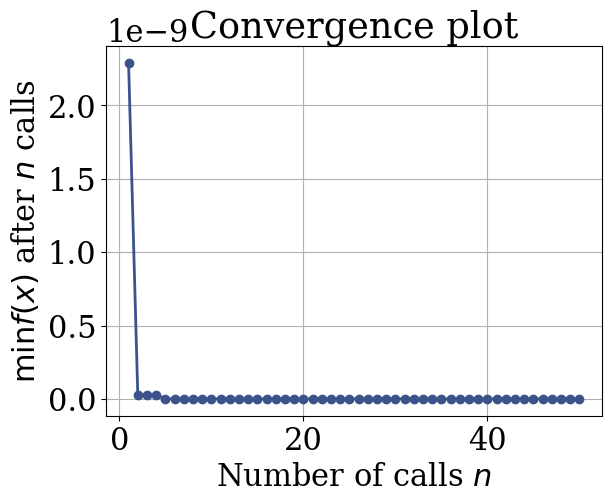

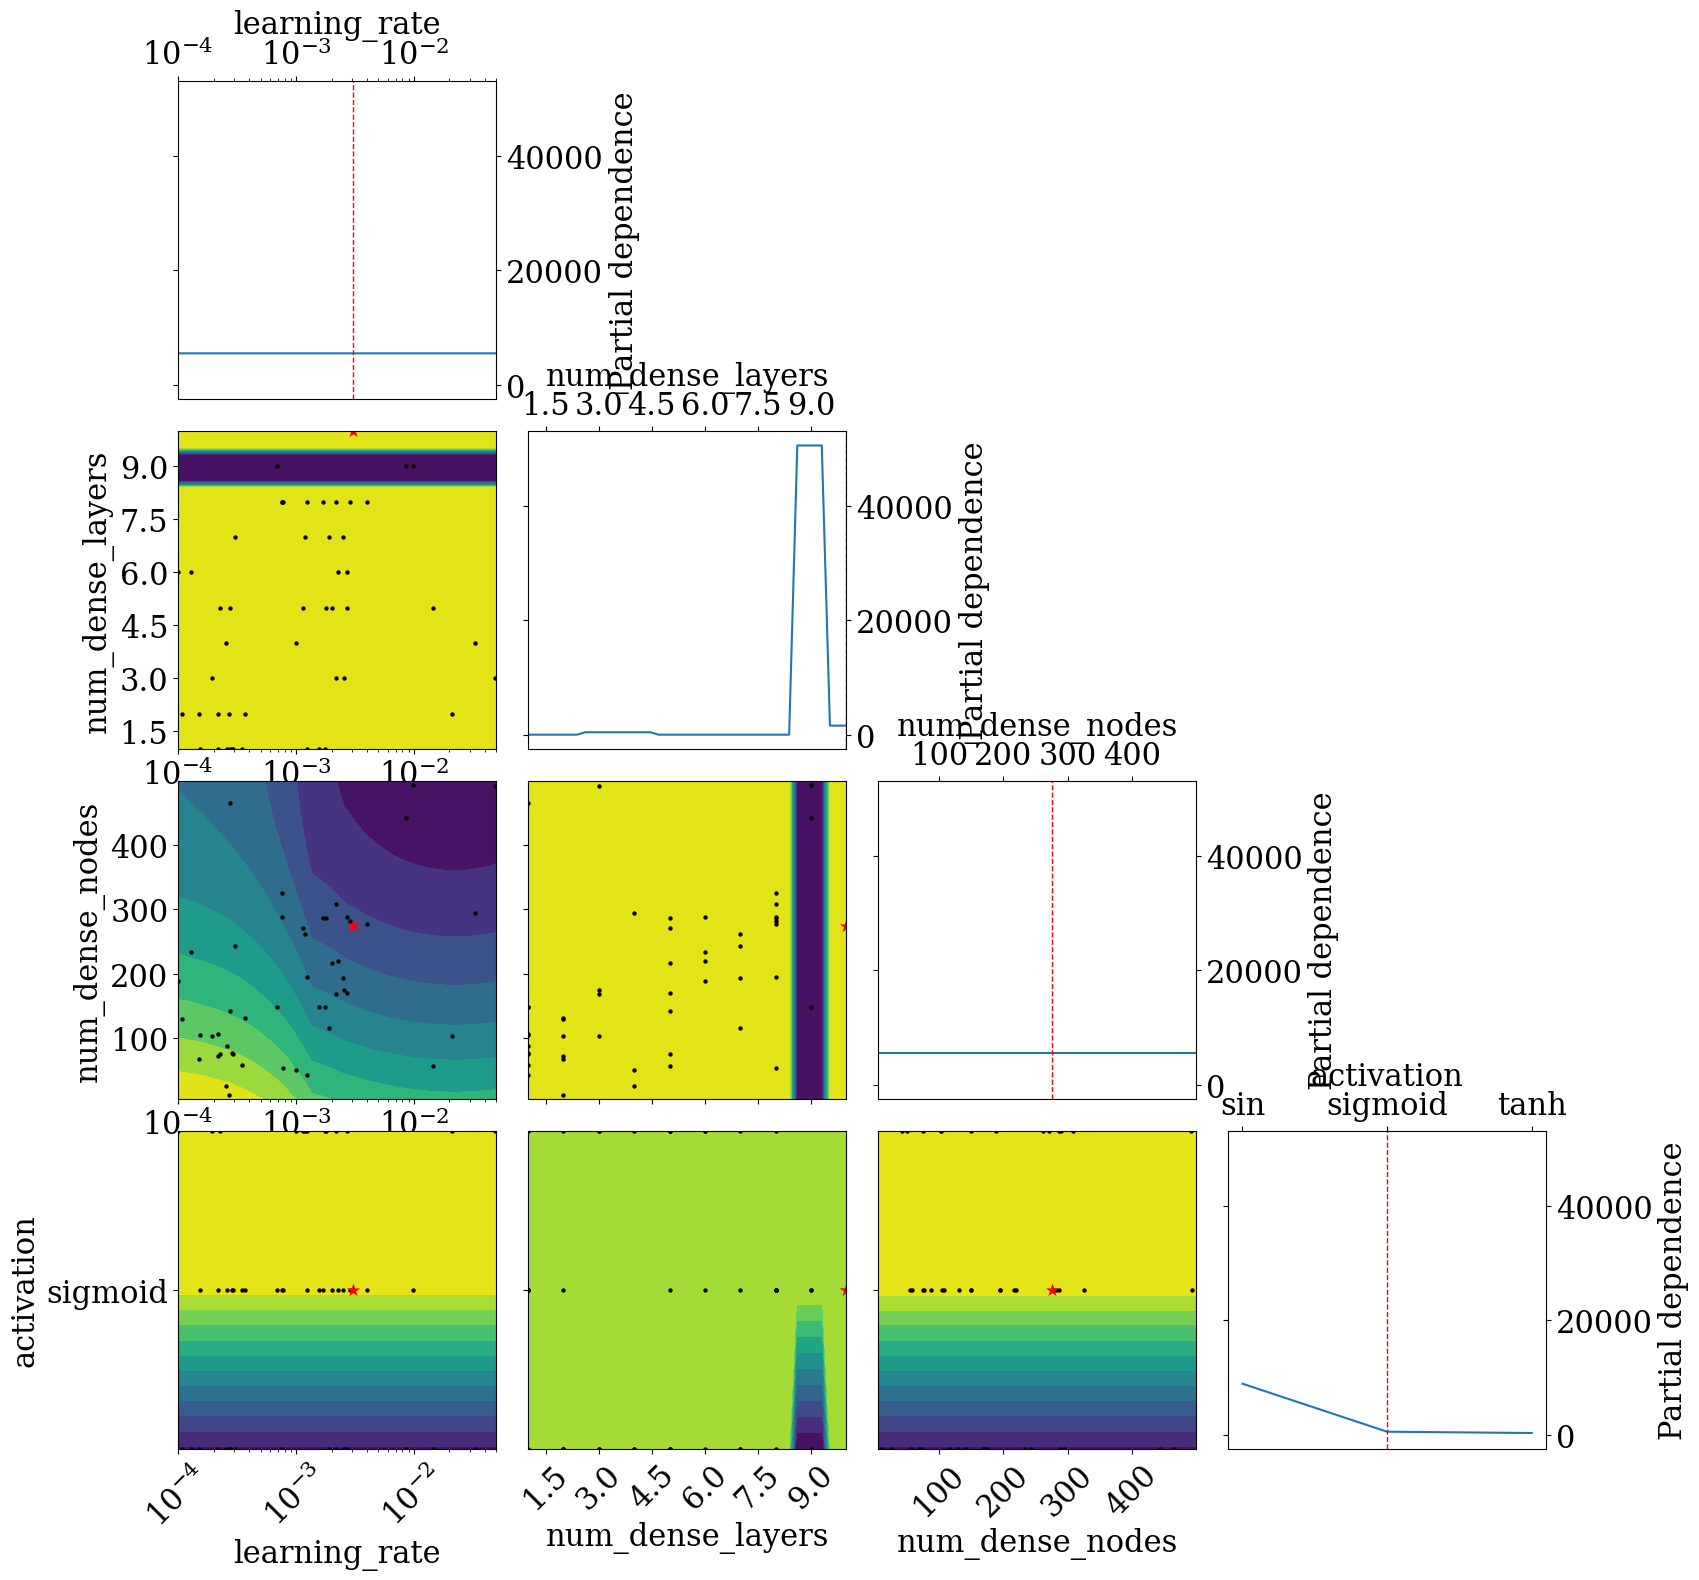

In [16]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

np.int = int

R = 1

precision_train = 15
precision_test = 30
iterations = 10000

def pde(x, y):
  du_xx = dde.grad.hessian(y, x, i=0, j=0)
  du_yy = dde.grad.hessian(y, x, i=1, j=1)

  return du_xx + du_yy

def boundary(x, on_boundary):
  return on_boundary

def boundary_top(x, on_boundary):
  return on_boundary and np.allclose(x, [0, 1])

def boundary_bottom(x, on_boundary):
  return on_boundary and np.allclose(x, [0, -1])

def boundary_left_right(x, on_boundary):
  return on_boundary and not boundary_top(x, on_boundary) and not boundary_bottom(x, on_boundary)

def boundary_d(x, on_boundary):
  return on_boundary and np.allclose(x, [0, 0])



def creat_model(config):
  learning_rate, num_dense_layers, num_dense_nodes, activation = config

  geom = dde.geometry.Disk([0,0], R)
  bc_top = dde.icbc.NeumannBC(geom, lambda x : 1 if boundary_top(x, True) else 0, boundary)
  bc_bottom = dde.icbc.NeumannBC(geom, lambda x : -1 if boundary_bottom(x,True) else 0, boundary)
  bc_round = dde.icbc.NeumannBC(geom, lambda x : 0 if boundary_left_right(x, True) else 0, boundary)
  bc_d = dde.icbc.DirichletBC(geom, lambda x : 0 if boundary_d(x, True) else 0, boundary)

  nx_train = int(3000)
  nx_test = int(1500)

  data = dde.data.PDE(
      geom,
      pde,
      [bc_top, bc_bottom, bc_round, bc_d],
      num_domain=nx_train,
      num_boundary=int(nx_train/10),
      num_test=nx_test,
  )

  net = dde.maps.FNN(
      [2] + [num_dense_nodes] * num_dense_layers + [1],
      activation,
      "Glorot uniform",
  )

  model = dde.Model(data, net)
  model.compile("adam", lr=learning_rate)
  return model

def train_model(model, config):
  losshistory, train_state = model.train(iterations=iterations)
  train = np.array(losshistory.loss_train).sum(axis=1).ravel()
  test = np.array(losshistory.loss_test).sum(axis=1).ravel()

  error = test.min()
  return error

n_calls = 50
dim_learning_rate = Real(low=1e-4, high=5e-2, name="learning_rate", prior="log-uniform")
dim_num_dense_layers = Integer(low=1, high=10, name="num_dense_layers")
dim_num_dense_nodes = Integer(low=5, high=500, name="num_dense_nodes")
dim_activation = Categorical(categories=["sin", "sigmoid", "tanh"], name="activation")

dimensions = [
    dim_learning_rate,
    dim_num_dense_layers,
    dim_num_dense_nodes,
    dim_activation,
]

default_parameters = [1e-3, 4, 50, "tanh"]

@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_dense_nodes, activation):
  config = [learning_rate, num_dense_layers, num_dense_nodes, activation]
  global ITERATION

  print(ITERATION, "it number")
  print("learning rate : {0:.1e}".format(learning_rate))
  print("num_dense_layers:", num_dense_layers)
  print("num_dense_nodes:", num_dense_nodes)
  print("activation:", activation)
  print()

  model = creat_model(config)
  error = train_model(model, config)

  if np.isnan(error):
    error = 10**5

  ITERATION += 1
  return error

ITERATION = 0

search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func="EI",  # Expected Improvement.
    n_calls=n_calls,
    x0=default_parameters,
    random_state=1234,
)

print(search_result.x)

plot_convergence(search_result)
plot_objective(search_result, show_points=True, size=3.8)
